Data Source : https://www.kaggle.com/bappekim/south-korea-visitors

Description by author : This dataset deals with the visitors of foreigners into South Korea.
It includes foreigners(not Korean), overseas Koreans and crew members, except for some of the foreign arrivals who are not considered tourists (diplomats, soldiers, permanent residents, visiting cohabitation and residence. (...) I created this dataset by rebuilding the data provided by KTO (Korea Tourim Organization) for easy analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Importing data

In [2]:
base_path = os.getcwd()
csv_by_age = os.path.join(base_path, 'tourism-data', 'inbound_korea_by_age.csv')
csv_by_gender = os.path.join(base_path, 'tourism-data', 'inbound_korea_by_gender.csv')
csv_by_purpose = os.path.join(base_path, 'tourism-data', 'inbound_korea_by_purpose.csv')

In [3]:
df_age = pd.read_csv(csv_by_age)
df_gender = pd.read_csv(csv_by_gender)
df_purpose = pd.read_csv(csv_by_purpose)

### Data Assessment and Cleaning

No null data and dataset are well documented and clean. Extra wrangling on data type only.

Convert to datetime and percent term in preparation of any calculation later.

In [4]:
dfs = [df_age, df_gender, df_purpose]

In [5]:
def toDatetime(df, col) :
    df[col] = pd.to_datetime(df[col])

In [6]:
def convertToPercent(df, col) :
    df[col] = df[col].apply(lambda x : x/100)

In [7]:
for df in dfs :
    toDatetime(df, 'date')
    convertToPercent(df, 'growth')
    convertToPercent(df, 'share')

Visitor by age total does not perfectly match with visitor total. So I create a column for this statistical error.

In [8]:
age_cols = ['age0-20', 'age21-30', 'age31-40', 'age41-50', 'age51-60', 'age61']

In [9]:
df_age.loc[:, age_cols].sum(axis=1) == df_age.visitor

0      False
1      False
2      False
3      False
4      False
       ...  
955    False
956    False
957    False
958    False
959     True
Length: 960, dtype: bool

In [10]:
df_age['error_count'] = df_age.visitor - df_age.loc[:, age_cols].sum(axis=1)

---
`df_gender`, `df_purpose` : the sum of the sub-category matches with the total visitor

In [11]:
( df_gender[['male', 'female', 'crewman']].sum(axis=1) == df_gender['visitor'] ).all()

True

In [12]:
( df_purpose[['tourism', 'business','official affairs', 'studying', 'others']]
     .sum(axis=1) == df_gender['visitor'] ).all()

True

---
### Merging and storing the dataset 

In [13]:
df_age.shape[0] == df_gender.shape[0] == df_purpose.shape[0]

True

In [14]:
temp1 = pd.merge(left=df_age, right=df_gender, how='outer', on = ['date', 'nation'])
temp1.head(3)

,date,nation,visitor_x,growth_x,share_x,age0-20,age21-30,age31-40,age41-50,age51-60,age61,error_count,visitor_y,growth_y,share_y,male,female,crewman
0,2019-01-01,China,392814,0.287379,0.355551,36520,108591,103657,48574,40893,40998,13581,392814,0.287379,0.355551,147511,231722,13581
1,2019-01-01,Japan,206526,0.236068,0.186935,18015,57921,34165,39811,33857,20330,2427,206526,0.236068,0.186935,75070,129029,2427
2,2019-01-01,Taiwan,87954,0.160037,0.079611,18888,17927,18595,18862,8169,4566,947,87954,0.160037,0.079611,30805,56202,947


Clean duplicates

In [15]:
def cleanDuplicates(df, col1, col2) : 
    if (df[col1] == df[col2]).all() :
        df.drop(columns = [col2], inplace = True)

In [16]:
cleanDuplicates(temp1, 'visitor_x', 'visitor_y')
cleanDuplicates(temp1, 'growth_x', 'growth_y')
cleanDuplicates(temp1, 'share_x', 'share_y')

In [17]:
temp2 = pd.merge(left = temp1, right = df_purpose, how = 'outer', on = ['date','nation'])
temp2.head(3)

,date,nation,visitor_x,growth_x,share_x,age0-20,age21-30,age31-40,age41-50,age51-60,...,female,crewman,visitor,growth,share,tourism,business,official affairs,studying,others
0,2019-01-01,China,392814,0.287379,0.355551,36520,108591,103657,48574,40893,...,231722,13581,392814,0.287379,0.355551,320113,2993,138,8793,60777
1,2019-01-01,Japan,206526,0.236068,0.186935,18015,57921,34165,39811,33857,...,129029,2427,206526,0.236068,0.186935,198805,2233,127,785,4576
2,2019-01-01,Taiwan,87954,0.160037,0.079611,18888,17927,18595,18862,8169,...,56202,947,87954,0.160037,0.079611,86393,74,22,180,1285


In [18]:
cleanDuplicates(temp2, 'visitor_x', 'visitor')
cleanDuplicates(temp2, 'growth_x', 'growth')
cleanDuplicates(temp2, 'share_x', 'share')

Edit column names

In [19]:
temp2.columns = temp2.columns.str.replace(' ','_')

In [20]:
temp2.columns = temp2.columns.str.replace('_x', '')

Store the clean data

In [21]:
temp2.to_csv('tourism-data/korea_tourism_inbound_clean_v1.csv', index = False)

---

In [22]:
df = pd.read_csv('tourism-data/korea_tourism_inbound_clean_v1.csv')

In [23]:
df.head()

,date,nation,visitor,growth,share,age0-20,age21-30,age31-40,age41-50,age51-60,age61,error_count,male,female,crewman,tourism,business,official_affairs,studying,others
0,2019-01-01,China,392814,0.287379,0.355551,36520,108591,103657,48574,40893,40998,13581,147511,231722,13581,320113,2993,138,8793,60777
1,2019-01-01,Japan,206526,0.236068,0.186935,18015,57921,34165,39811,33857,20330,2427,75070,129029,2427,198805,2233,127,785,4576
2,2019-01-01,Taiwan,87954,0.160037,0.079611,18888,17927,18595,18862,8169,4566,947,30805,56202,947,86393,74,22,180,1285
3,2019-01-01,Hong Kong,35896,0.035332,0.032491,3890,11384,7400,5461,4629,2137,995,12172,22729,995,34653,59,2,90,1092
4,2019-01-01,Macao,2570,-0.123764,0.002326,223,1013,762,264,181,92,35,748,1787,35,2506,2,0,17,45


---
### `1` Which country visited Korea the most?

In [24]:
useCols = df.columns.difference(['growth','share'], sort=False)
df_country = df[useCols]

stats_by_country = df_country.groupby('nation').sum().sort_values('visitor', ascending=False)

In [25]:
visitorTotal = stats_by_country.visitor.sum()
visitorPerc = stats_by_country.visitor / visitorTotal

In [26]:
stats_by_country.insert(loc=1, column='visitor_perc', value = visitorPerc)
stats_by_country.insert(loc=2, column='visitor_perc_accum', value = visitorPerc.cumsum())

In [27]:
# Narrow down to top 90% countries
top90Perc = stats_by_country.query('visitor_perc_accum <= 0.90')  

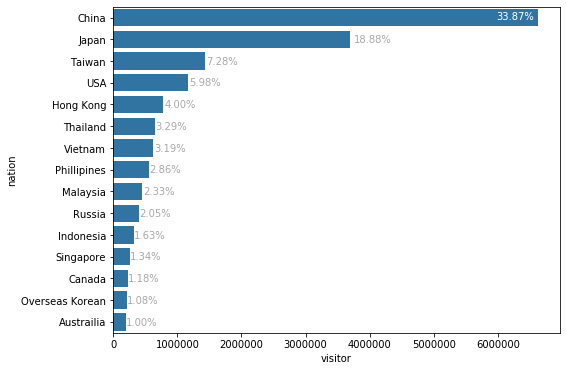

In [28]:
base_color = sns.color_palette()[0]
plt.figure(figsize = [8,6])

sns.barplot(data=top90Perc, y=top90Perc.index, x='visitor', color=base_color);

perc_values = top90Perc.visitor_perc
num_values = top90Perc.visitor

for i in range(len(num_values)):
    x_value = num_values[i]
    string = '{:.2f}%'.format(perc_values[i] * 100)
    if i == 0:
        plt.text(x = x_value * 0.90, y = i+0.1, s = string, color='white');
    else: 
        plt.text(x = x_value * 1.015, y = i+0.14, s = string, color='darkgrey');

Mainland China is the most visited country to Korea in the given period, with a large porportion upto 33.87%.
Followed by Japan (18.88%), Taiwan (7.28%) with relatively lower percentage of total visitor volume.

---
### `2` How has the vistor volumn evolved over time from the top 90% countries?

COVID-19 started around Dec 2019 from Mainland China, and spread over to Asian countries starting January 2020. I expect an obvious drop in visitation from 2020 onwards.

Additionally, there was a political tension between Korea and Japan starting starting from early 2019. The tension was grown amid the Japanese government's trade restrictions which was officialized since July 2019. I would like to see how much impact this poticial tension has put on inbound tourism from Japanest market.

In [29]:
visitor_trend = df[['date','nation','visitor']]

In [30]:
trendByCountry = visitor_trend.pivot(index='date',columns='nation',values='visitor')

In [31]:
top90PercCountries = top90Perc.index # narrow down to top 90% countries by visitation
trendByTop90Perc = trendByCountry.loc[:,top90PercCountries]

In [32]:
total = trendByTop90Perc.sum(axis=1)
trendByTop90Perc.insert(loc=0, column='total', value=total)

In [33]:
# Remove the unnecessary day ('-01')
tempIdx = trendByTop90Perc.index.str.split('-').str[0:-1]
new_index = ['-'.join(idx) for idx in tempIdx]
trendByTop90Perc.index = new_index

In [34]:
loc = [tick for tick in range(0, len(trendByTop90Perc.index) ,3)]

In [40]:
value = [trendByTop90Perc.index[i] for i in range(0, len(trendByTop90Perc.index) ,3)]

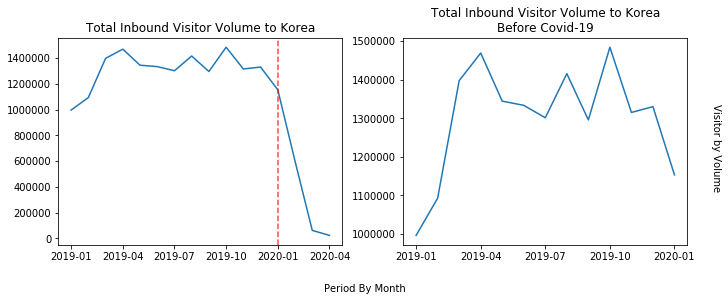

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,4])
fig.tight_layout(pad=3.0)

ax1.plot(trendByTop90Perc.total, label='Total');
ax1.axvline(x = '2020-01', c = 'red', alpha = 0.7, ls='--');
ax1.set_title('Total Inbound Visitor Volume to Korea');
ax1.set_xticks(loc);

visitByCountry_2019 = trendByTop90Perc[trendByTop90Perc.index < '2020-01-01']
ax2.plot(visitByCountry_2019.total)
ax2.set_title('Total Inbound Visitor Volume to Korea\nBefore Covid-19');
ax2.set_xticks(loc[0:-1])

fig.text(0.5, 0, 'Period By Month', ha='center')
fig.text(0.98, 0.5, 'Visitor by Volume', va='center', rotation='270');

It is obvious that the impact of COVID-19 is awfully big on inbound tourism to Korea in 2020 onwards, possibly starting from December 2019. The spread of COVID-19 was drastic in Mainland China early 2020, which resulted in the huge drop of visitor in January 2020 as shown in the below figure.

Putting apart the effect of COVID-19, the total visitor volume topped in April and September, throughout 2019. 

More time series data is needed for a thorough trend analysis. However, observations tell that the visitation is likely higher as the two months have the best weather to hang outside in Korea. August visitation was relatively high as well, which I assumed is the effect of summer holiday in Asia. 

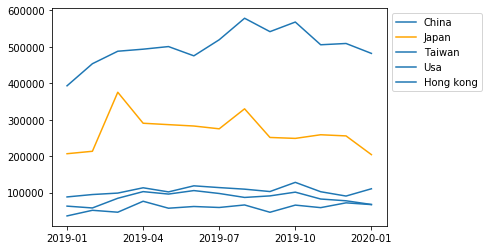

In [42]:
base_color = sns.color_palette()[0]

for col in visitByCountry_2019.columns[1:6] :
    if col == 'Japan' : 
        plt.plot(visitByCountry_2019[col], label=col.capitalize(), color = 'orange')
    else :
        plt.plot(visitByCountry_2019[col], label=col.capitalize(), color = base_color)

plt.xticks(ticks = loc[0:-1], labels = value[0:-1]);
plt.legend(loc='best', bbox_to_anchor = [1,1]);

However, although the overall trend is decreasing from quater 2, there is not much of dramatic change in Japanese inbound visitation throughout 2019. Therefore, it is yet too early to say there was a relationship between the adverse political environment and the tourism.

Still, this leaves a further study year on year trend for Japanest inbound tourism.

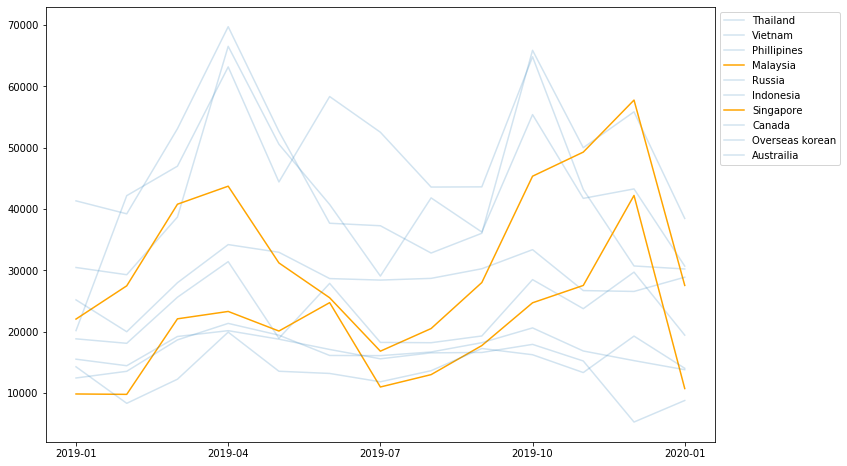

In [50]:
plt.figure(figsize = [12,8])

base_color = sns.color_palette()[0]
country_interested = ['Malaysia', 'Singapore'];

for col in visitByCountry_2019.columns[6:] :
    if col in country_interested : 
        plt.plot(visitByCountry_2019[col], label=col.capitalize(), color='orange')
    else :
        plt.plot(visitByCountry_2019[col], label=col.capitalize(),
                 color=base_color, alpha=0.2)

plt.xticks(ticks = loc[0:-1], labels = value[0:-1]);
plt.legend(loc='best', bbox_to_anchor=[1,1]);

The other top 90 percent countries in visitation : the simmilar trend is identified in 2019 that the visitation is higher around April and September.

On the other hand, there is noticeable variance in seasonality trend particularly for two South East Asian countries; Malaysia and Singapore. Starting from early-July, we can see continous increase in visitation from both countries, which tops near early-winter. Assuming all other factors constant, my experiences tell that the weather impact played a role : the visitors of the two countries prefer to enjoy cold weathers in Korea as they only have summer season througout the year. This insight may need a further quantitative validation.

---
### `3` What is the general purpose of visit to Korea from the top 90% countries?

In [51]:
colsPurpose = ['visitor', 'tourism', 'business', 'official_affairs', 'studying', 'others']

In [52]:
purposeByTop90Perc = top90Perc[colsPurpose]

In [53]:
# data validation
( purposeByTop90Perc.visitor == purposeByTop90Perc.iloc[:,1:].sum(axis=1) ).all()

True

In [54]:
totalVisitors = purposeByTop90Perc.visitor.sum()
totalByPurpose = purposeByTop90Perc.sum(axis=0)

stats_purpose = pd.DataFrame({'total_visitor_mil' : totalByPurpose / 1000000, 
                              'perc_total' : totalByPurpose / totalVisitors * 100})
stats_purpose = stats_purpose.sort_values(by = 'total_visitor_mil', 
                                          ascending=False)
stats_purpose

,total_visitor_mil,perc_total
visitor,17.609572,100.000000
tourism,14.762904,83.834542
others,2.280024,12.947640
studying,0.391890,2.225437
business,0.110366,0.626739
official_affairs,0.064388,0.365642


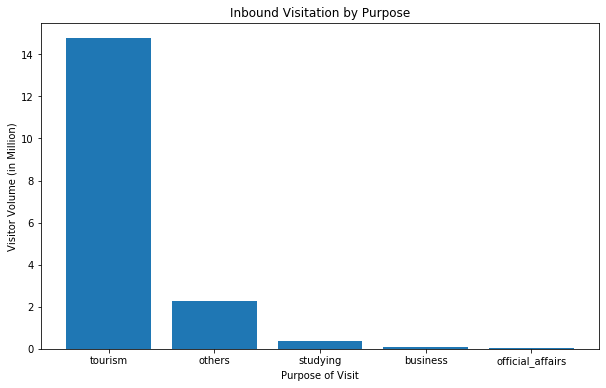

In [61]:
plt.figure(figsize = [10,6])
plt.bar(height = stats_purpose.iloc[1:, 0], x = stats_purpose.index[1:]);

plt.title('Inbound Visitation by Purpose');
plt.xlabel('Purpose of Visit');
plt.ylabel('Visitor Volume (in Million)');

A majority of tourists from the top 90% countries visit Korea for the pure Tourism purpose (83.8%), for the given period (Jan 2019 - Apr 2020).

---
### `4` Does age have an impact on inbound tourism to Korea?

In [69]:
top90Perc.head()

,visitor,visitor_perc,visitor_perc_accum,age0-20,age21-30,age31-40,age41-50,age51-60,age61,error_count,male,female,crewman,tourism,business,official_affairs,studying,others
nation,,,,,,,,,,,,,,,,,,
China,6629318,0.338687,0.338687,423696,1894302,1835184,864272,760557,675872,175435,2478590,3975293,175435,5341847,47709,5067,277895,956800
Japan,3695581,0.188804,0.527491,426179,1079631,571123,638839,550992,393140,35677,1268356,2391548,35677,3585819,28194,2264,16333,62971
Taiwan,1424629,0.072783,0.600275,205193,310609,324283,275737,173153,123098,12556,469668,942405,12556,1399668,1154,221,5662,17924
USA,1170719,0.059811,0.660086,142704,189609,189678,180639,197195,187620,83274,587328,500117,83274,885065,5449,41533,6396,232276
Hong Kong,783159,0.040011,0.700097,108546,164546,143710,145289,129163,80922,10983,267098,505078,10983,766312,765,52,3286,12744


In [119]:
colAge = ['visitor', 'age0-20', 'age21-30', 'age31-40', 'age41-50', 'age51-60', 'age61', 'error_count']

In [120]:
# Converted to Million
ageByTop90Perctop90_mil = round(top90Perc[colAge] / 1000000, 4)

In [121]:
# Making a summary stats table
ageStats = ageByTop90Perctop90_mil.sum()

ageStatstotal = ageStats.visitor
ageStatsPerc = (ageStats / total).iloc[1:,]
ageStatsindex = ageStatsPerc.index

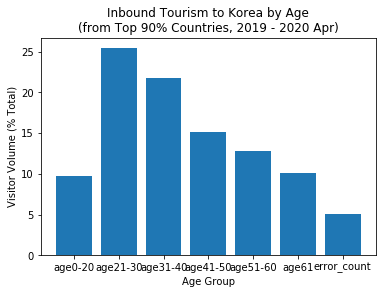

In [122]:
plt.bar(height = ageStatsPerc * 100 , x = ageStatsindex);

plt.title('Inbound Tourism to Korea by Age\n(from Top 90% Countries, 2019 - 2020 Apr)')
plt.xlabel('Age Group')
plt.ylabel('Visitor Volume (% Total)');

In the given period of interest (2019 - 2020 Apr), 25% of the total visitors age between 21 - 30, which presumably are university students & employeed in their early career.
Not much difference is seen for vistor between age 31 - 40 (around 22%), whereas the vistiation is following the decrasing line as age becomes higher. 

Note the graph accounts for around 5% of survey error, represented by error_count.

---
### `5` Is there any significant difference in vistiation among genders?

In [123]:
colGender = ['visitor', 'male', 'female', 'crewman']

In [130]:
genderByTop90Perctop90_mil = round(top90Perc[colGender] / 1000000, 4)

In [140]:
# Visitation from crew members (crewman) is not relavent -> substract
totalVisitor = genderByTop90Perctop90_mil.visitor
crewman = genderByTop90Perctop90_mil.crewman
totalVisitor_adj = totalVisitor - crewman

In [144]:
genderByTop90Perctop90_mil.drop(columns = ['visitor', 'crewman'], inplace = True)

In [150]:
# Making a summary stats table
genderStats = genderByTop90Perctop90_mil.sum()

genderStatsPerc = genderStats / totalVisitor_adj.sum()
genderStatsindex = genderStatsPerc.index

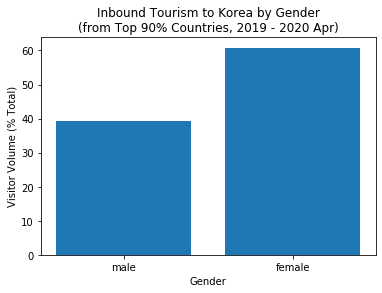

In [154]:
plt.bar(height = genderStatsPerc * 100 , x = genderStatsindex);

plt.title('Inbound Tourism to Korea by Gender\n(from Top 90% Countries, 2019 - 2020 Apr)')
plt.xlabel('Gender')
plt.ylabel('Visitor Volume (% Total)');

It is 60 : 40 porportion that inbound tourism consists of more female than male visitors. 